<a href="https://colab.research.google.com/github/idanvidra/SIREN_tasks_explored/blob/main/Cogntiv_DeepLearning_Exercise1_Idan_Vidra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thanks to the following sources for insperation:
1. SIREN paper - https://arxiv.org/pdf/2006.09661.pdf
2. SIREN authors exploration colab notebook - https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb#scrollTo=jE2RbD7k0UyB
3. mathiasare SIREN coloration colab notebook - https://github.com/mathiasare/SIREN-ImageColorizerProject

# **Drive**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATA_PATH = r'/content/drive/MyDrive/Work/Cogntiv/Data'
MODEL_PATH = r'/content/drive/MyDrive/Work/model'

# **Imports**

In [28]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, Grayscale, ToPILImage

import PIL
from PIL import Image
import skimage
from skimage.io import imread_collection,imsave
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

import os
import re
import time

# **Utils**

In [5]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

# def lin2img(tensor, img_res=None, h_and_w=48, channels=3):
#   '''
#   convert vector tensor to image stack
#   '''
#   batch_size, num_samples, channels = (h_and_w, h_and_w, channels)
#   if img_res is None:
#     width = np.sqrt(num_samples).astype(int)
#     height = width
#   else:
#     height = img_res[0]
#     width = img_res[1]

#   return tensor.permute(0,2,1).view(batch_size, channels, height, width)

# def rescale_img(x, mode='scale', perc=None, tmax=1.0, tmin=0.0):
#   if mode == 'scale':
#     if perc is None:
#       xmax = torch.max(x)
#       xmin = torch.min(x)
#     else:
#       xmin = np.percentile(x.detach().cpu().numpy(), perc)
#       xmax = np.percentile(x.detach().cpu().numpy(), 100 - perc)
#     if xmin == xmax:
#       return 0.5 * torch.ones_like(x) * (tmax - tmin) + tmin
#     x = ((x - xmin) / (xmax - xmin)) * (tmax - tmin) + tmin
#   elif mode == 'clamp':
#     x = torch.clamp(x, 0, 1)
#   return x

def get_image_from_data(name, size=48):
  '''
  return requested image from dataset path in drive (PIL Image object)
  '''
  return Image.open(DATA_PATH + f'/{size}/{name}-{size}.png').convert('RGB')

def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

# **Neural Representations NN**

In [6]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords, idx=None):
        '''
        run input through network.
        if the network is trained on several images the idx of the image is given.
        the idx is added as a third value for each coordinate value (x,y,idx)

        outputs a color value (r,g,b) for each coordinate (x,y)
        '''
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input

        # train on multuple images
        if idx is not None:
          idx = idx.clone().detach()
          # concatinate coordiantes and idx
          x = torch.cat((coords, idx), dim=-1)
          output = self.net(x)
        # train on singal image
        else:
          output = self.net(coords)    
        
        return output, coords        

    # def forward_with_activations(self, coords, retain_grad=False):
    #     '''Returns not only model output, but also intermediate activations.
    #     Only used for visualizing activations later!'''
    #     activations = OrderedDict()

    #     activation_count = 0
    #     x = coords.clone().detach().requires_grad_(True)
    #     activations['input'] = x
    #     for i, layer in enumerate(self.net):
    #         if isinstance(layer, SineLayer):
    #             x, intermed = layer.forward_with_intermediate(x)
                
    #             if retain_grad:
    #                 x.retain_grad()
    #                 intermed.retain_grad()
                    
    #             activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
    #             activation_count += 1
    #         else: 
    #             x = layer(x)
                
    #             if retain_grad:
    #                 x.retain_grad()
                    
    #         activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
    #         activation_count += 1

    #     return activations

# **Image Handling**

In [8]:
def get_img(img, sidelength=128):
    '''
    given image return the image transformed (resized and normalized) and permutated
    '''
    transform = Compose([
        Resize((sidelength,sidelength)),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    img = img.permute(1, 2, 0)
    return img


# def read_img(i, lr, hr, size):
#   lr_img = lr[i]
#   hr_img = hr[i]
#   return (get_img(lr_img, size), get_img(hr_img, size))

# def transform(data, sidelength=48):
#   transfrom = Compose([
#       Resize((sidelength, sidelength)),
#       Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
#   ])
#   data = transform(data)
#   return data

def read_from_path(path):
  '''
  given path return all the images in that path.
  each image is transformed into a tensor and moved to cuda.
  '''
  images = []
  dirFiles = os.listdir(path)
  dirFiles.sort(key=lambda f: int(re.sub('\D', '', f)))
  for filename in dirFiles:
    img = Image.open(path+"/"+filename).convert('RGB')
    transfrom = Compose([
      ToTensor()
    ])
    img = transfrom(img).cuda()
    if img is not None:
      images.append(img)
  return images

# **Dataset**

In [9]:
class ImageFitting(Dataset):
    '''
    dataset for images

    imgs - array of training images
    sidelength - imgs size
    
    for upsampling use:
    imgs_hr - array of high resolution training images (optional)
    sidelength_hr - imgs_hr size (optional)
    '''
    def __init__(self, sidelength, img_input, img_input_hr = None, sidelength_hr=None):
        super().__init__()
        self.imgs = img_input
        self.imgs_hr = img_input_hr
        self.sidelength = sidelength
        self.sidelength_hr = sidelength_hr

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):    
        
        img = self.imgs[idx]

        # if testing upsampling
        if self.imgs_hr: 
          img_hr = self.imgs_hr[idx]

        pixels = img.permute(1, 2, 0).view(self.sidelength,self.sidelength,3)
        coords = get_mgrid(self.sidelength, 2)
        
        # if testing upsampling
        if self.imgs_hr: 
          img_hr = self.imgs_hr[idx]
          pixels_hr = img_hr.permute(1, 2, 0).view(self.sidelength_hr,self.sidelength_hr,3)
          coords_hr = get_mgrid(self.sidelength_hr, 2)

        # if testing upsampling
        if self.imgs_hr:
          return coords, pixels, idx, coords_hr, pixels_hr

        else:
          return coords, pixels, idx

# **Eval Functions**

In [10]:
def show_image_for_eval(img_siren, dataloader, size_img=48, upsample_mode=False):
  '''
  used to show the models output on an image from the dataset

  img_siren - trained SIREN model
  dataloader - dataset dataloader
  size_img - the output images size (optional)
  upsample_mode - use when we want to check SIREN's ability to upsample images 
  '''

  # collect coordinates, ground truth image and index
  if not upsample_mode:
    model_input, ground_truth, idx = next(iter(dataloader))
    ground_truth = ground_truth.resize(1, 1, size_img**2, 3)
  else:
    _, _, idx, model_input_hr, ground_truth_hr = next(iter(dataloader))
    ground_truth = ground_truth_hr.resize(1, 1, size_img**2, 3)
    model_input = model_input_hr

  # move to cuda device
  model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

  # prepare idx layer to combine with coordiantes
  idx_for_net = torch.tensor(np.ones((1, size_img**2, 1)) * idx.numpy()).float().cuda()
  
  # run through network
  with torch.no_grad():
    model_output, coords = img_siren(model_input, idx_for_net)
  
  loss = float (((model_output - ground_truth )**2).mean())

  # show reuslts
  print("Loss after training %0.6f" % loss)

  fig, axes = plt.subplots(1,2, figsize=(15,6))
  axes[0].set_title("Model Output")
  axes[0].imshow(model_output.cpu().view(size_img,size_img, 3).detach().numpy())

  axes[1].set_title("Model Input")
  axes[1].imshow(ground_truth.cpu().view(size_img,size_img, 3).detach().numpy())
  plt.show()

# **Train Function**

In [11]:
def train(batch_size, total_steps=1000, steps_till_summary=250, size_img=48):
  '''
  function to train network

  batch_size - size of training images batch
  total_steps - number of total training steps (optional)
  steps_till_summary - number of training steps untill feedback (optional)
  size_img - size of training images
  '''

  # init
  losses = []
  optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
  
  for step in range(total_steps):
    total_loss = []
    for k in range(batch_size):
      
      # get coordinates, image and index
      model_input, ground_truth, idx = next(iter(dataloader))
      ground_truth=ground_truth.resize(1, 1, size_img**2, 3)

      # move to cuda
      model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

      # prepare idx layer to combine with coordiantes
      idx_for_net = torch.tensor(np.ones((1, size_img**2, 1)) * idx.numpy()).float().cuda()

      # run through network
      model_output, coords = img_siren(model_input, idx_for_net)

      # calculate loss
      loss = ((model_output - ground_truth) ** 2).mean()

      # save for analyzing training
      total_loss.append(loss.detach().cpu().numpy())
      
      # learning step
      optim.zero_grad()
      loss.backward(retain_graph=True)
      optim.step()

    # show progress
    losses.append(np.mean(total_loss))
    if step % steps_till_summary == 0:
      print(f"Step {step}, mean total loss: {np.mean(total_loss)}")
      show_image_for_eval(img_siren, dataloader)
      

  return losses

# **Task I - Image Representation**

In [17]:
'''
Init model
'''
img_siren = Siren(in_features=3, out_features=3, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [18]:
'''
Init training data
'''
col_dir1 = DATA_PATH + '/48'
col_dir2 = DATA_PATH + '/48'

lr = read_from_path(col_dir1)
hr = read_from_path(col_dir2)

train_pics = ImageFitting(48, lr)
dataloader = DataLoader(train_pics, batch_size=1, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Step 0, mean total loss: 0.1389736384153366
Loss after training 0.124003


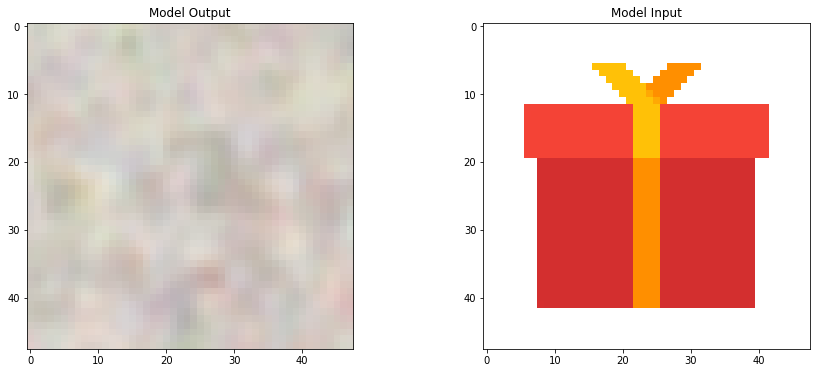

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, mean total loss: 0.009008428081870079
Loss after training 0.011678


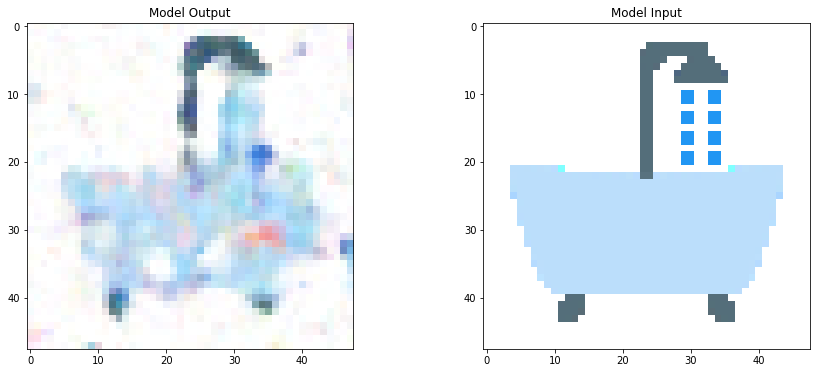

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, mean total loss: 0.008818463422358036
Loss after training 0.007152


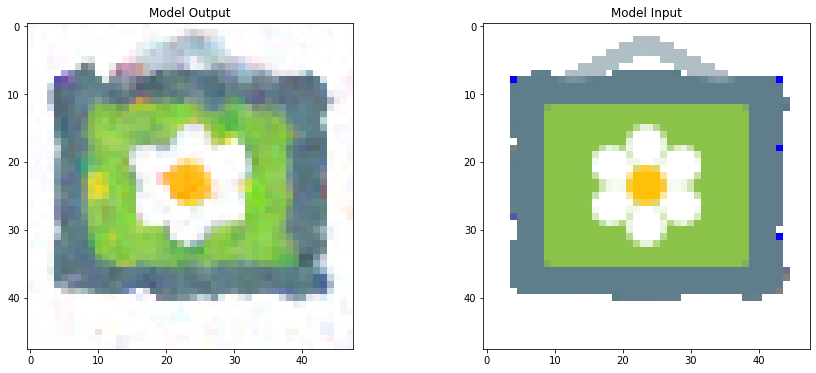

In [19]:
'''
Train model
'''
losses = train(100,total_steps=1001,steps_till_summary=500,size_img=48)

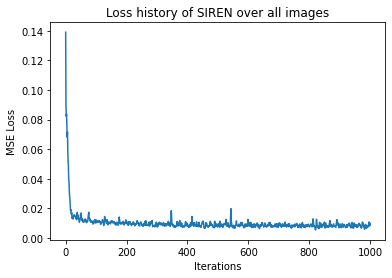

In [20]:
'''
Analyzing loss over time
'''
# losses_numpy = [loss.detach().cpu().numpy() for loss in losses]

plt.title("Loss history of SIREN over all images")
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.plot(losses)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss after training 0.007556


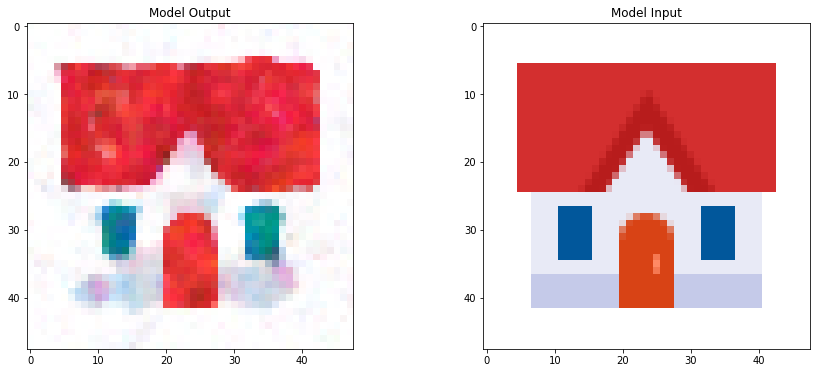

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss after training 0.004792


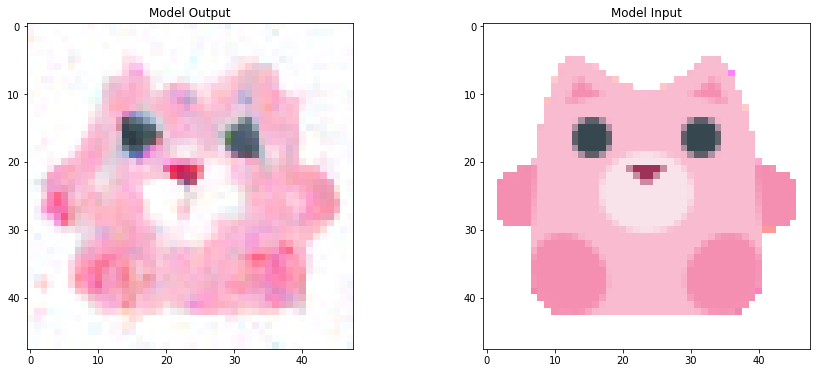

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss after training 0.015685


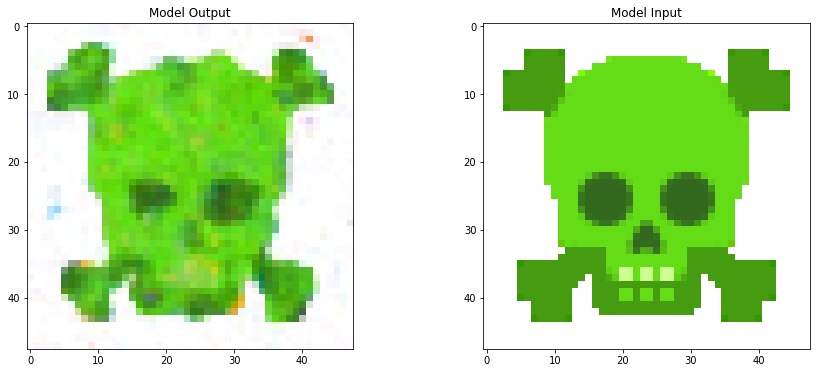

In [21]:
'''
Demonstrate model's results
'''
for i in range(3):
  show_image_for_eval(img_siren, dataloader)

In [36]:
'''
Save model
'''
save_mode = False
if save_mode:
  torch.save(img_siren.state_dict(), MODEL_PATH)

# **Task II - Upsample**

In [22]:
'''
Init model
'''
img_siren = Siren(in_features=3, out_features=3, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)

# load pretrained model (trained on Task I)
img_siren.load_state_dict(torch.load(MODEL_PATH))
img_siren.eval()
img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [23]:
'''
Init training data
'''
col_dir1 = DATA_PATH + '/48'
col_dir2 = DATA_PATH + '/256' # high resolution data

lr = read_from_path(col_dir1)
hr = read_from_path(col_dir2)

train_pics = ImageFitting(sidelength=48, img_input=lr, img_input_hr = hr, sidelength_hr=256)
dataloader = DataLoader(train_pics, batch_size=1, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss after training 0.024728


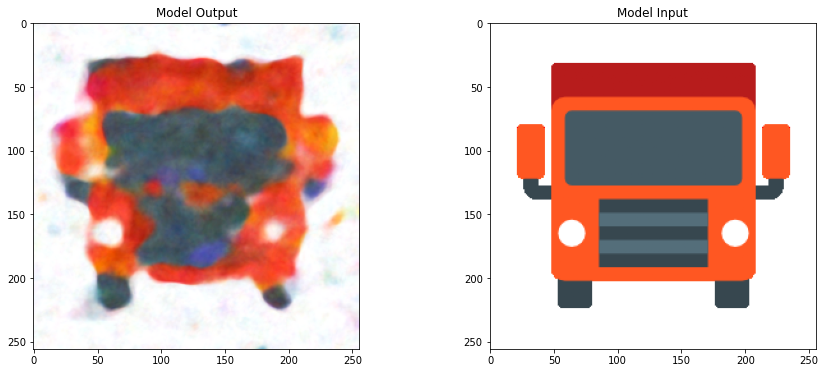

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss after training 0.680856


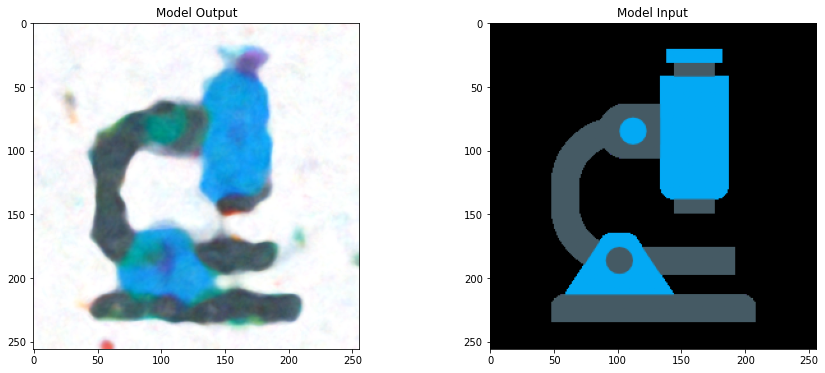

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss after training 0.010856


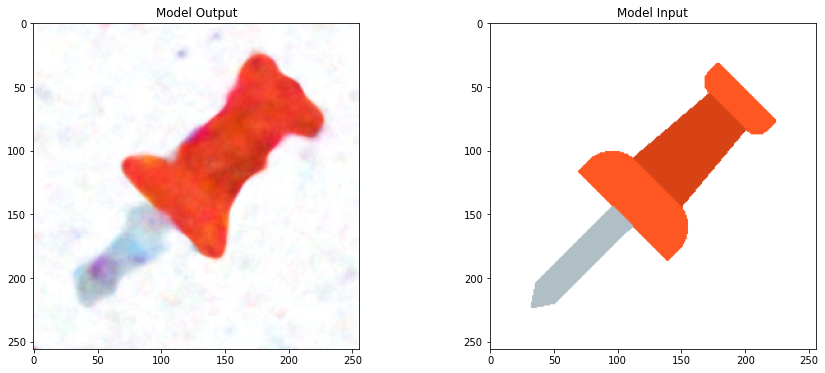

In [24]:
for i in range(3):
  show_image_for_eval(img_siren, dataloader, size_img=256, upsample_mode=True)

# **Task III - Image Interpolation**

In [25]:
'''
Init model
'''
img_siren = Siren(in_features=3, out_features=3, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [26]:
'''
Init training data
'''
col_dir1 = DATA_PATH + '/48'
col_dir2 = DATA_PATH + '/48'

lr = read_from_path(col_dir1)
hr = read_from_path(col_dir2)

train_pics = ImageFitting(sidelength=48, img_input=lr)
dataloader = DataLoader(train_pics, batch_size=1, shuffle=True)

In [27]:
def get_two_images(sidelength):
  '''
  return two random images from the 48X48 dataset
  '''

  ground_truth_images = []
  non_grey_gorund_truth_images = []

  for i in range(2):

    model_input, ground_truth, idx = next(iter(dataloader))

    # save RGB images
    non_grey_gorund_truth_images.append(ground_truth)

    # convert to greyscale
    ground_truth = Grayscale()(ground_truth.squeeze().permute(2, 0, 1)).permute(0,1,2)

    # save greyscale images
    ground_truth_images.append(ground_truth)

  return ground_truth_images[0], ground_truth_images[1], non_grey_gorund_truth_images[0], non_grey_gorund_truth_images[1]

In [31]:
class CombineDataset(Dataset):
    '''
    dataset for images

    returns:
    coords - image coordiantes
    pixels - image 1
    grads - gradient of combined ground truth images
    combined_img - naive combination of ground truth images
    '''
    def __init__(self, sidelength):
        super().__init__()
        img_1, img_2, non_grey_img_1, non_grey_img_2 = get_two_images(sidelength)
        
        # img_1
              
        grads_x_1 = scipy.ndimage.sobel(img_1.cpu().numpy(), axis=1).squeeze(0)[..., None]
        grads_y_1 = scipy.ndimage.sobel(img_1.cpu().numpy(), axis=2).squeeze(0)[..., None]
        grads_x_1, grads_y_1 = torch.tensor(grads_x_1), torch.tensor(grads_y_1)

        # img_2
        # Compute gradient and laplacian 
        grads_x_2 = scipy.ndimage.sobel(img_2.cpu().numpy(), axis=1).squeeze(0)[..., None]
        grads_y_2 = scipy.ndimage.sobel(img_2.cpu().numpy(), axis=2).squeeze(0)[..., None]
        grads_x_2, grads_y_2 = torch.tensor(grads_x_2), torch.tensor(grads_y_2)

        grads_x = torch.div(torch.add(grads_x_1,grads_x_2), 2)
        grads_y = torch.div(torch.add(grads_y_1,grads_y_2), 2)
                
        self.grads = torch.stack((grads_x, grads_y), dim=-1).view(-1, 2)
        # self.laplace = scipy.ndimage.laplace(img.numpy()).squeeze(0)[..., None]
        # self.laplace = torch.from_numpy(self.laplace)
        
        
        self.pixels = img_1.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
        self.combined_img = torch.div(torch.add(non_grey_img_1, non_grey_img_2), 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.coords, {'pixels':self.pixels, 'grads':self.grads, 'combined_img':self.combined_img}

In [32]:
def gradients_mse(model_output, coords, gt_gradients):
    '''
    compute loss over gradients
    '''
    # compute gradients on the model
    gradients = gradient(model_output, coords)
    # compare them with the ground-truth
    gradients_loss = torch.mean((gradients - gt_gradients).pow(2).sum(-1))
    return gradients_loss

In [33]:
def combine_two_images(size_img = 48, total_steps = 201, steps_til_summary = 50):
  # init dataloader
  img_combiner = CombineDataset(48)
  dataloader_1 = DataLoader(img_combiner, batch_size=1, num_workers=0)

  # init model
  poisson_siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                        hidden_layers=3, outermost_linear=True)
  poisson_siren.cuda()

  # init optimizer
  optim = torch.optim.Adam(lr=1e-4, params=poisson_siren.parameters())

  # init
  model_input, gt = next(iter(dataloader_1))
  gt = {key: value.cuda() for key, value in gt.items()}
  model_input = model_input.cuda()

  for step in range(total_steps):

      # run through model
      model_output, coords = poisson_siren(model_input)

      # compute loss
      train_loss = gradients_mse(model_output, coords, gt['grads'])

      # update to screen
      if not step % steps_til_summary:
          print(f"Step {step}, Total loss {train_loss}")

          # get output gradient and laplacian
          img_grad = gradient(model_output, coords)
          img_laplacian = laplace(model_output, coords)
          
          # convert output to PIL greyscale
          img = ToPILImage()(model_output.cpu().view(size_img,size_img,3).detach().permute(2,0,1))
          img = PIL.ImageOps.grayscale(img)

          # print to screen
          fig, axes = plt.subplots(1, 5, figsize=(18, 6))
          axes[0].imshow(img, cmap='Pastel1')
          axes[1].imshow(img_grad.cpu().norm(dim=-1).view(size_img,size_img).detach().numpy())
          axes[2].imshow(img_laplacian.cpu().view(size_img,size_img).detach().numpy())
          axes[3].imshow(gt['grads'].norm(dim=-1).view(size_img,size_img).detach().cpu().numpy())
          axes[4].imshow(gt['combined_img'].cpu().view(size_img,size_img,3).detach().numpy())

          axes[0].set_title("Model Output")
          axes[1].set_title("Model Output Grad")
          axes[2].set_title("Model Output Laplace")
          axes[3].set_title("Combined Input Grads")
          axes[4].set_title("Ground Truth")
          plt.show()
      
      # learning step
      optim.zero_grad()
      train_loss.backward()
      optim.step()

Step 0, Total loss 8.145992, iteration time 0.002238


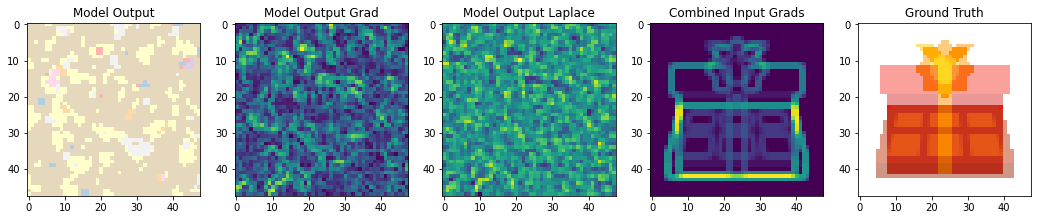

Step 50, Total loss 0.008177, iteration time 0.001805


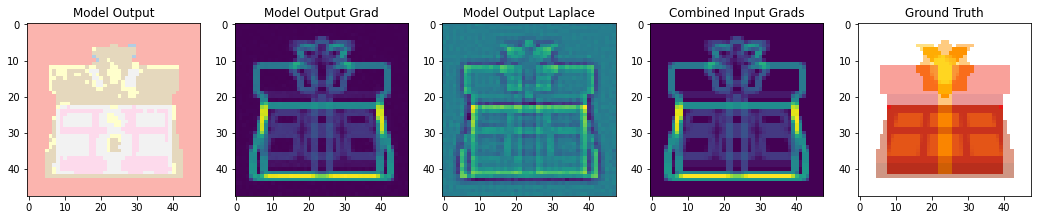

Step 100, Total loss 0.002353, iteration time 0.001644


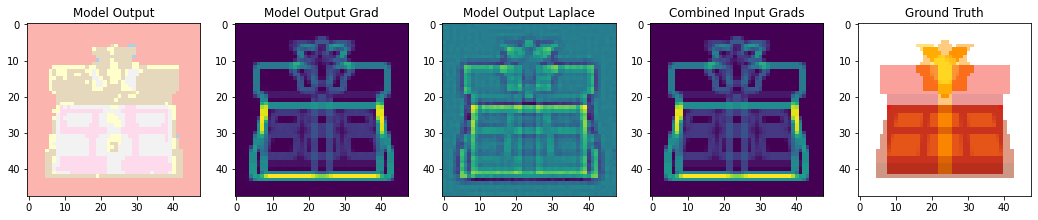

Step 150, Total loss 0.003358, iteration time 0.001708


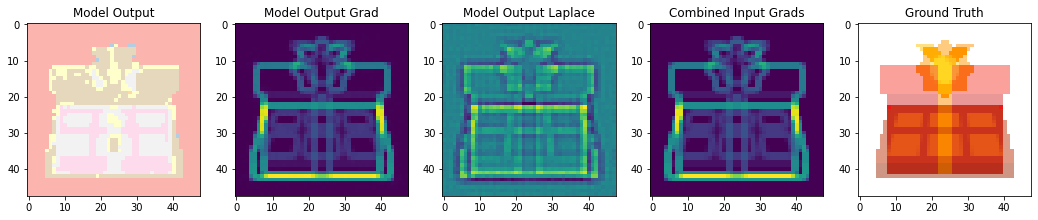

Step 200, Total loss 0.001239, iteration time 0.001784


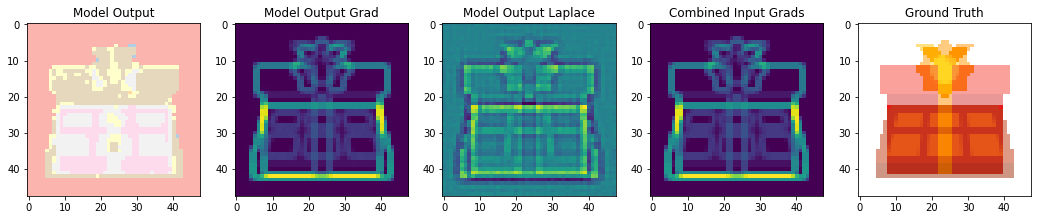

In [156]:
combine_two_images()

Step 0, Total loss 5.783097267150879


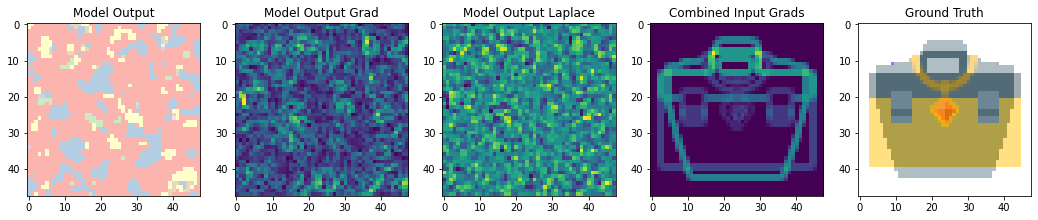

Step 50, Total loss 0.006922504864633083


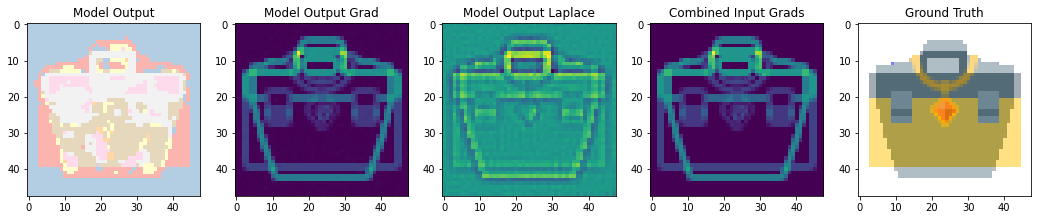

Step 100, Total loss 0.0020157131366431713


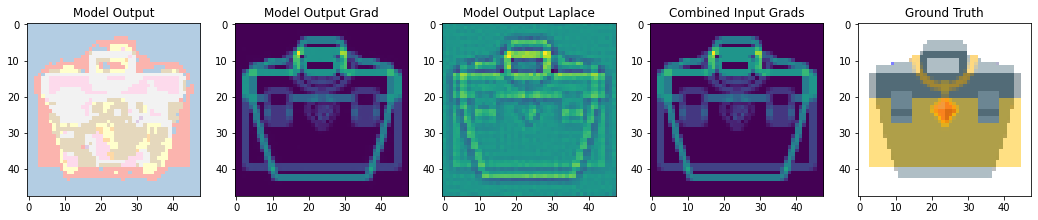

Step 150, Total loss 0.0012056472478434443


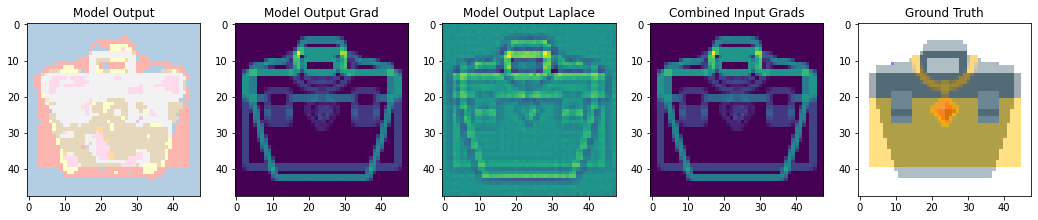

Step 200, Total loss 0.0007717053522355855


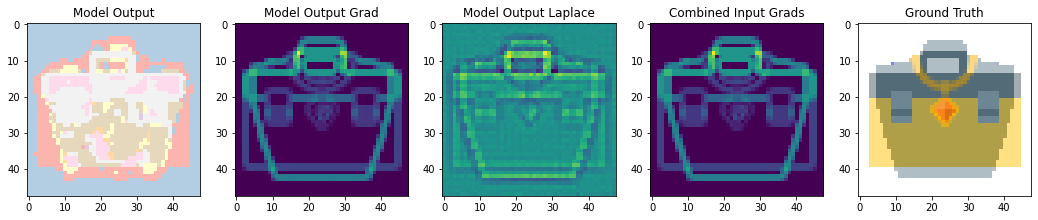

In [34]:
combine_two_images()

Step 0, Total loss 7.226950, iteration time 0.001981


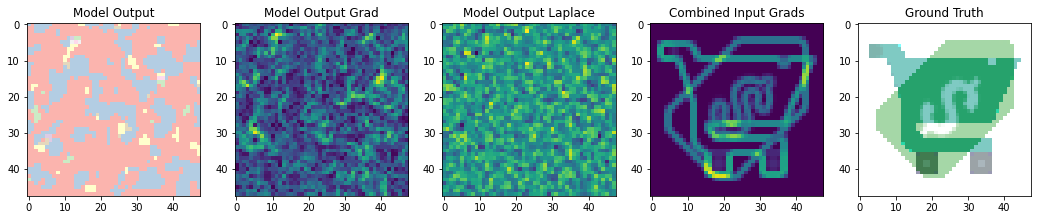

Step 50, Total loss 0.008576, iteration time 0.001686


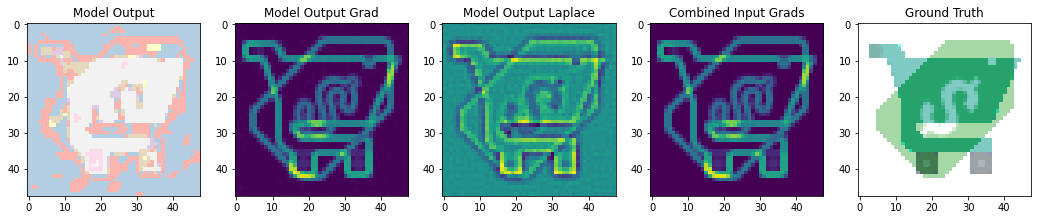

Step 100, Total loss 0.002892, iteration time 0.001848


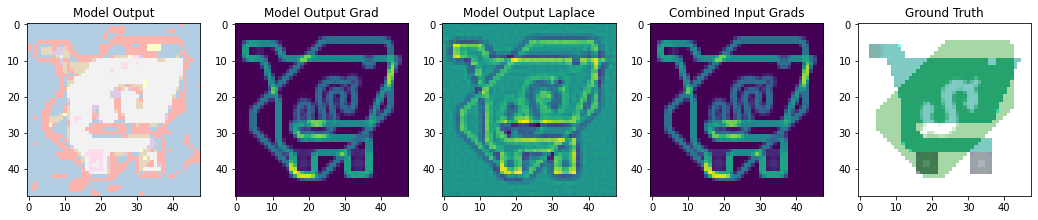

Step 150, Total loss 0.001879, iteration time 0.001750


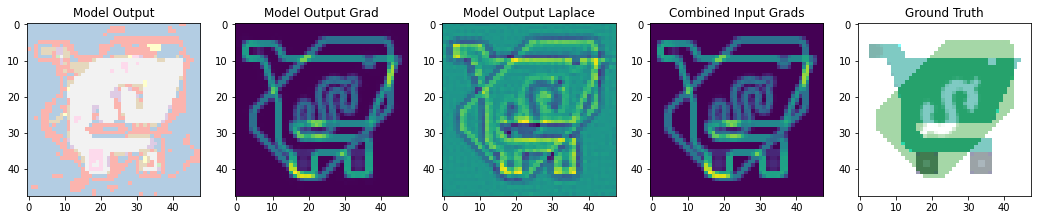

Step 200, Total loss 0.001567, iteration time 0.001765


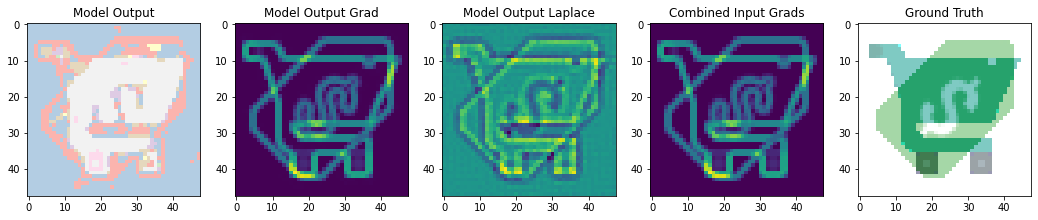

In [165]:
combine_two_images()